In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from steinberg_utils_3vertex import *
from general_graph_utils import *

In [2]:
# plot formatting
plt.rc("text", usetex=False) # renders LaTeX more quickly
plt.rc("font", family = "serif",size=14) # font specifications
plt.rc("figure",figsize=(14,12)) # figure size
%config InlineBackend.figure_format = 'retina' # retina-display quality

1. Are autocorrelation functions $\mathcal{A}^{\alpha,\beta}(\tau)$ always monotonic decreasing? 
2. Does one of the curves $\mathcal{A}^{\alpha,\beta}(\tau)$ or $\mathcal{A}^{\beta,\alpha}(\tau)$ always lie above the other, or do the two curves cross for positive values of $\tau$? 
3. Does this separation of the two curves always occur for all sets of parameter values? 

In [3]:
params = random_parameters()
print(params)

[1.23719717e-03 5.21696662e-02 7.10512481e-02 2.11654664e+00
 7.03879274e-02 9.23924616e-02]


In [4]:
L = Laplacian_K(params)
L

array([[-7.16251246e-02,  5.21696662e-02,  9.23924616e-02],
       [ 1.23719717e-03, -1.23220914e-01,  2.11654664e+00],
       [ 7.03879274e-02,  7.10512481e-02, -2.20893910e+00]],
      dtype=float128)

In [5]:
pi = steady_state_MTT(params)
pi

array([0.43150506, 0.53745752, 0.03103742], dtype=float128)

In [8]:
# double check SS function works
pi_2 = steady_state_spectrum(L)
pi_2

array([[0.43150506],
       [0.53745752],
       [0.03103742]])

In [9]:
signal = [3, 5, 7]
alpha = 1
beta = 3

In [21]:
tau = np.around(np.arange(0.01,40.0,step=.01), decimals = 2)

In [22]:
a_13, a_31 = autocorrelation_analytical_final(signal,L,tau,pi,alpha,beta)

In [23]:
a_13 >= a_31

array([False, False, False, ..., False, False, False])

In [24]:
a_31 >= a_13

array([ True,  True,  True, ...,  True,  True,  True])

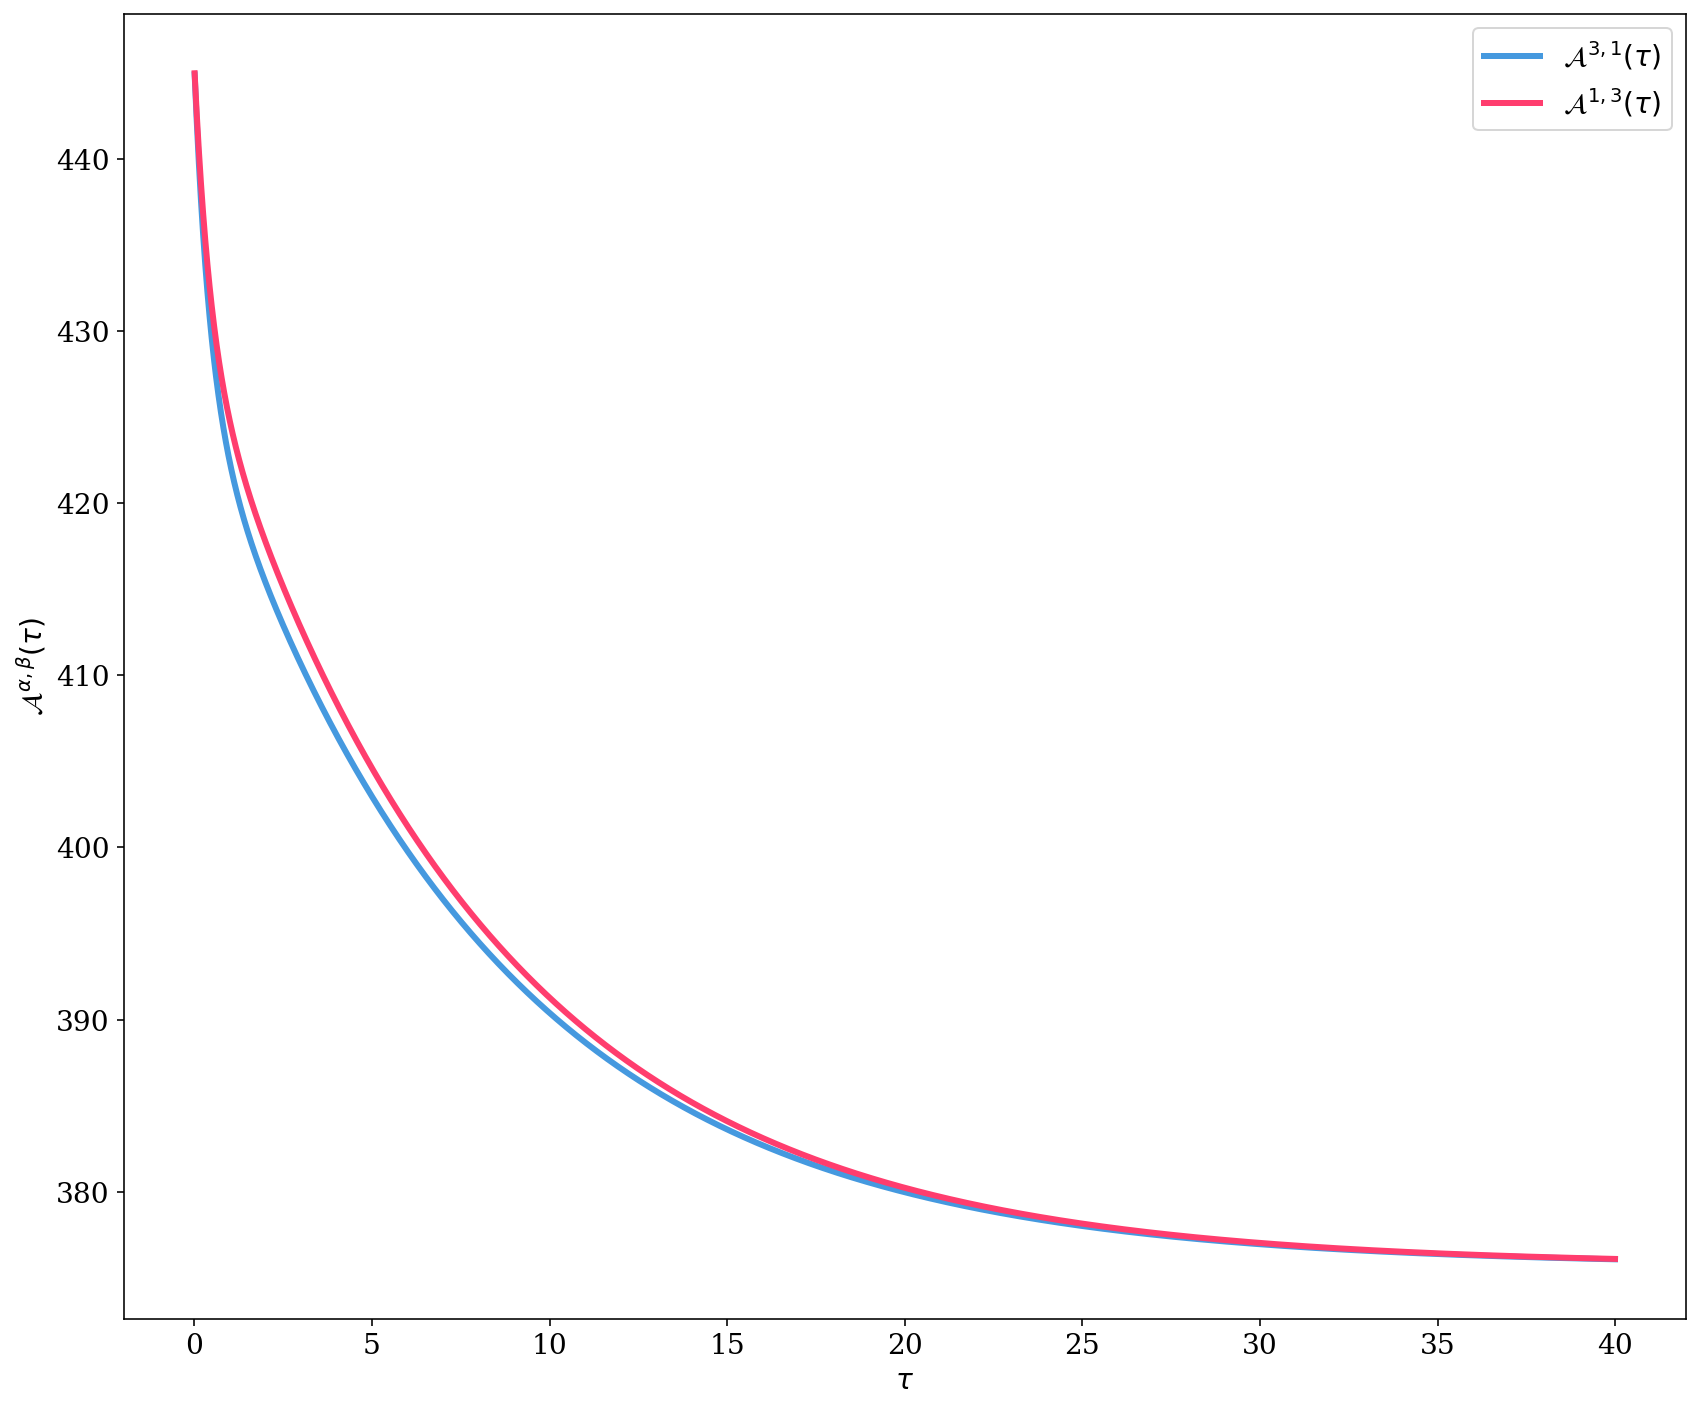

In [25]:
fig = plt.figure()
plt.plot(tau,a_13,label=r'$\mathcal{A}^{3,1}(\tau)$',linewidth=3, c= '#4599DF')
plt.plot(tau,a_31,label=r'$\mathcal{A}^{1,3}(\tau)$',linewidth=3,color='#FF3D6E')
plt.xlabel(r"$\tau$")
plt.ylabel(r"$\mathcal{A}^{\alpha,\beta}(\tau)$")
plt.legend()
plt.show()

In [ ]:
tau = np.around(np.arange(0.01,40.0,step=.01), decimals = 2)
signal = [3, 5, 7]
alpha = 1
beta = 3

for i in range(100):
    params = random_parameters()
    L = Laplacian_K(params)
    pi = steady_state_MTT(params)
    a_13, a_31 = autocorrelation_analytical(signal,L,tau,pi,alpha,beta)
    